# Skin Cancer Detection Model


In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import DenseNet121, DenseNet169
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools


%matplotlib inline

Using TensorFlow backend.


# Loading & Preprocessing

I use a Ben & Cropping Method to preprocess the images, such that details and colors are enhanced

In [2]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".jpg":
            img = read(PATH)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (RESIZE,RESIZE))
            img = cv2.addWeighted (img,4, cv2.GaussianBlur( img, (0,0) , sigmaX) ,-4 ,128)
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/data/train/benign',224))
malign_train = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/data/train/malignant',224))
benign_test = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/data/test/benign',224))
malign_test = np.array(Dataset_loader('../input/skin-cancer-malignant-vs-benign/data/test/malignant',224))

100%|██████████| 300/300 [00:04<00:00, 68.19it/s]


# Create Label

In [3]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

# Train and Evalutation split
Now we can split it into a training and validation set.

In [4]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

# Display Some Images

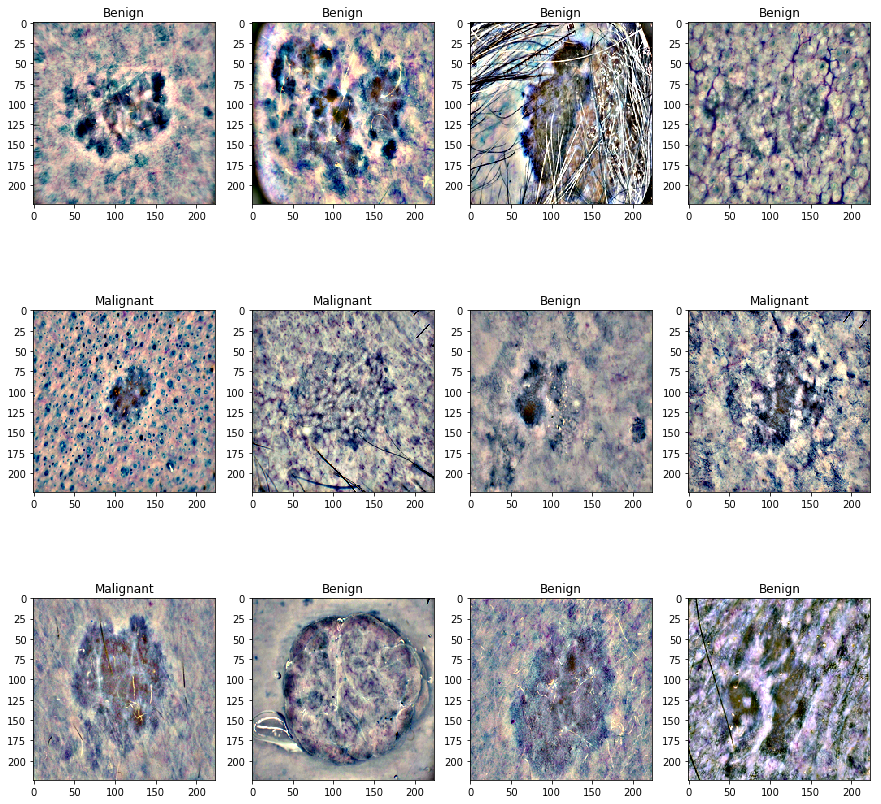

In [5]:

# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

# Data Generator

In [6]:
BATCH_SIZE = 32

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=0.5,  # set range for random zoom
        rotation_range = 45,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

# Model: DenseNet-169

In [7]:
def build_model(backbone, lr=5e-5):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [8]:
K.clear_session()
gc.collect()

densenet169 = DenseNet169(
    weights='../input/densenet-keras/DenseNet-BC-169-32-no-top.h5',
    include_top=False,
    input_shape=(224,224,3)
)

model = build_model(densenet169 ,lr = 1e-4)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1664)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1664)              6656      
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1704960   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096      
__________

In [9]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

# Training & Evaluation

In [10]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=25,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/25
66/65 [==============================] - 92s 1s/step - loss: 0.7287 - acc: 0.6643 - val_loss: 0.4432 - val_acc: 0.8220

Epoch 00001: val_acc improved from -inf to 0.82197, saving model to weights.best.hdf5
Epoch 2/25
66/65 [==============================] - 33s 497ms/step - loss: 0.5302 - acc: 0.7856 - val_loss: 0.3326 - val_acc: 0.8523

Epoch 00002: val_acc improved from 0.82197 to 0.85227, saving model to weights.best.hdf5
Epoch 3/25
66/65 [==============================] - 35s 537ms/step - loss: 0.4206 - acc: 0.8247 - val_loss: 0.2461 - val_acc: 0.8939

Epoch 00003: val_acc improved from 0.85227 to 0.89394, saving model to weights.best.hdf5
Epoch 4/25
66/65 [==============================] - 35s 526ms/step - loss: 0.3924 - acc: 0.8401 - val_loss: 0.2630 - val_acc: 0.9015

Epoch 00004: val_acc improved from 0.89394 to 0.90152, saving model to weights.best.hdf5
Epoch 5/25
66/65 [==============================] - 34s 522ms/step - loss: 0.3451 - acc: 0.8552 - val_loss: 0.3376

In [11]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

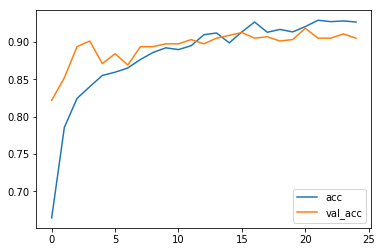

In [12]:
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot()

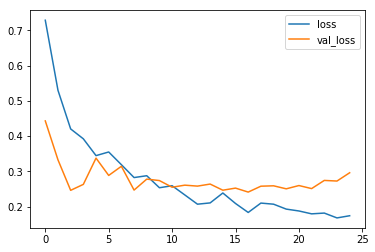

In [13]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

# Prediction

In [14]:
model.load_weights("weights.best.hdf5")

In [15]:
Y_val_pred = model.predict(x_val)

In [16]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.9185606060606061

In [17]:
Y_pred = model.predict(X_test)

# Test Time Augmentation


In [18]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)

100%|██████████| 10/10 [01:26<00:00,  8.67s/it]


# Evaluation
### Accuracy Score

In [19]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

0.8863636363636364

In [20]:
accuracy_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

0.896969696969697

### Confusion Matrix

Confusion matrix, without normalization
[[308  52]
 [ 23 277]]


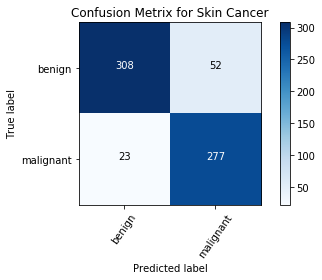

In [21]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[332  28]
 [ 40 260]]


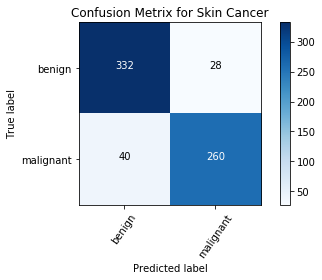

In [25]:
cm = confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')


Normalized confusion matrix
[[0.92222222 0.07777778]
 [0.13333333 0.86666667]]


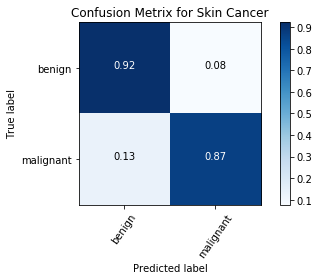

In [26]:
plot_confusion_matrix(cm, cm_plot_label,normalize=True, title ='Confusion Metrix for Skin Cancer')

In [27]:
from sklearn.metrics import classification_report
classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))

'              precision    recall  f1-score   support\n\n           0       0.89      0.92      0.91       360\n           1       0.90      0.87      0.88       300\n\n    accuracy                           0.90       660\n   macro avg       0.90      0.89      0.90       660\nweighted avg       0.90      0.90      0.90       660\n'

### ROC and AUC

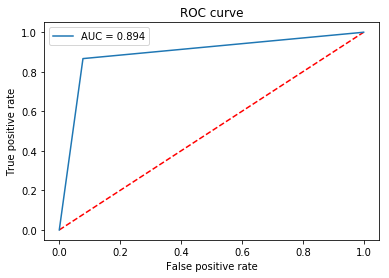

In [28]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

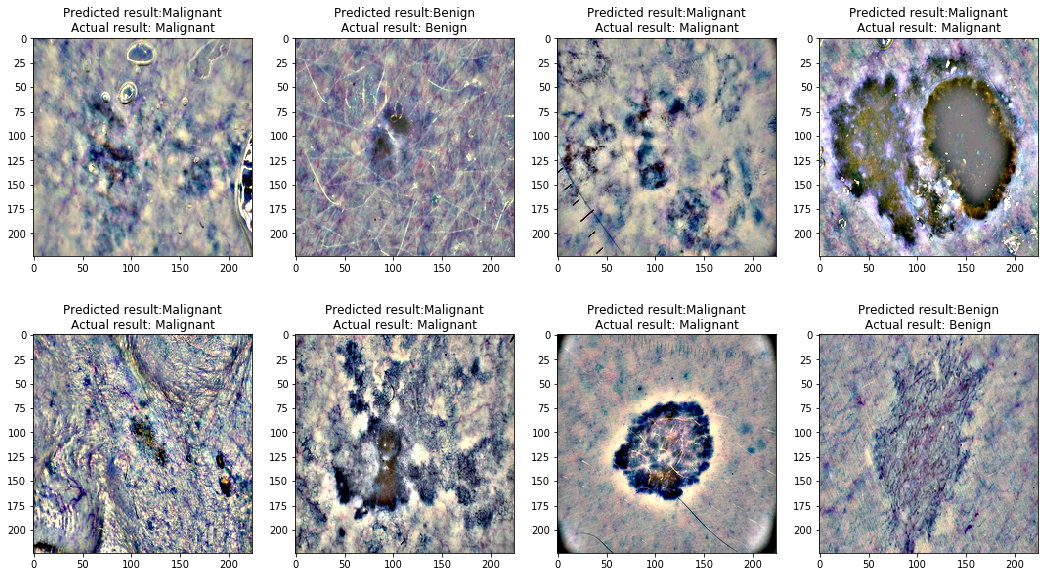

In [29]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test)):
    if(np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test)):
    if(not np.argmax(Y_test[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

# Save Model

In [30]:
# save model
# serialize model to JSON
model_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("densenet.h5")
print("Saved model to disk")

Saved model to disk
